# Solar

In [138]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.ticker as ticker

import numpy as np
import random
from pathlib import Path
from tqdm import tqdm
import torch
torch.manual_seed(10) 
import torch.optim as optim
import torch.nn as nn
import platform
from PIL import Image
from PIL.ImageStat import Stat
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, RandomApply, ColorJitter, ToPILImage
import ipyplot
from torchmetrics import JaccardIndex
from torchmetrics.functional import jaccard_index
from processing import BigImage
import datetime
import json
from constants import ROOT

from step_by_step import StepByStep, InverseNormalize, load_tensor, get_means_and_stdevs 
from categorize import check_for_missing_files, LABELS, show_image, overlay_two_images
from models import Segnet
plt.style.use('fivethirtyeight')

def get_current_datetime():
    return datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data processing

In [2]:
proj_dir = Path('.').resolve().parent
data_dir = proj_dir / 'data'
labeled_imgs_dir = data_dir / 'labeled/imgs'
labeled_masks_dir = data_dir / 'labeled/masks'

image_paths = labeled_imgs_dir.glob('*.png')
mask_paths = labeled_masks_dir.glob('*.png')

# some weird buf where linux finds extra files that start with '.'
image_paths = filter(lambda x: x.name[0] != '.', image_paths)
mask_paths = filter(lambda x: x.name[0] != '.', mask_paths)

image_paths = filter(lambda x: x.name != 'smallpost', image_paths)
mask_paths = filter(lambda x: x.name != 'smallpost', mask_paths)

image_paths = sorted(list(image_paths))
mask_paths = sorted(list(mask_paths))

check_for_missing_files(image_paths, mask_paths)

In [3]:
title_mapping = {0: 'background', 1: 'racks', 2: 'panels'}

In [4]:
def get_tensors(image_paths, mask_paths):

    n_channels, h, w = ToTensor()(Image.open(image_paths[0]).convert('RGB')).shape

    x_tensor = torch.zeros([len(image_paths), n_channels, h, w])
    y_tensor = torch.zeros([len(image_paths), h, w], dtype=torch.long)  # we'll have only class number mask

    for i, (image_path, mask_path) in enumerate(zip(tqdm(image_paths), mask_paths)):
        x_tensor[i,:,:,:] = ToTensor()(Image.open(image_path).convert('RGB'))

        mask = Image.open(mask_path).convert('RGB')
        mask_tensor = ToTensor()(mask)

        # let's extracts only relevant channel (0 - red for rack, 2 - blue for panel):
        # we don't have mixed labels
        if 'commonpanel' in image_path.name:
            mask_tensor = mask_tensor[2, :, :]
            class_id = 1
        elif 'rack' in image_path.name:
            mask_tensor = mask_tensor[0, :, :]
            class_id = 2
        else:
            # this is pure zeros
            mask_tensor = mask_tensor[0, :, :]
            class_id = 0
            
        # make it binary
        mask_tensor = (mask_tensor > mask_tensor.min()).long()
        
        # multiply with class_id
        mask_tensor *= class_id
    
        y_tensor[i,:,:] = mask_tensor

    return x_tensor, y_tensor 

In [5]:
labeled_tensor_x, labeled_tensor_y = get_tensors(image_paths, mask_paths)

100%|██████████| 505/505 [00:03<00:00, 152.01it/s]


In [6]:
unlabeled_imgs_dir = data_dir / 'unlabeled'
unlabeled_image_paths = sorted(list(unlabeled_imgs_dir.glob('*.png')))

In [7]:
N = len(unlabeled_image_paths) 
n_channels, h, w = ToTensor()(Image.open(unlabeled_image_paths[0]).convert('RGB')).shape

unlabeled_tensor_x = torch.zeros([len(unlabeled_image_paths[:N]), n_channels, h, w])
unlabeled_tensor_y = torch.zeros([len(unlabeled_image_paths[:N]), h, w], dtype=torch.long)  # we'll have only class number mask
idx_map = {}

for i, image_path in enumerate(tqdm(unlabeled_image_paths[:N])):
    unlabeled_tensor_x[i, :, :, :] = ToTensor()(Image.open(image_path))
    unlabeled_tensor_y[i,:,:] = torch.zeros(*unlabeled_tensor_x.shape[2:])
    idx_map[i] = image_path.name

100%|██████████| 6477/6477 [00:24<00:00, 260.62it/s]


## Augmentations

In [8]:
jitter = ColorJitter(brightness=(0.2, 1.0), contrast=(0.3, 1.0))  # jitter will change every time it is called
applier = RandomApply(torch.nn.ModuleList([jitter]), p=0.3)

## Split into train, valid, and test

We'll use `torch.utils.data.random_split`:

In [9]:
torch.manual_seed(13)
N = len(labeled_tensor_x)
n_train = int(.85*N)
n_val = N - n_train
train_subset, val_subset = random_split(labeled_tensor_x, [n_train, n_val])

train_idx = train_subset.indices
val_idx = val_subset.indices

train_tensor_x = labeled_tensor_x[train_idx]
train_tensor_y = labeled_tensor_y[train_idx]
val_tensor_x = labeled_tensor_x[val_idx]
val_tensor_y = labeled_tensor_y[val_idx]

print(train_tensor_x.shape, train_tensor_x.dtype)
print(train_tensor_y.shape, train_tensor_y.dtype)
print(val_tensor_x.shape, val_tensor_x.dtype)
print(val_tensor_y.shape, val_tensor_y.dtype)

torch.Size([429, 3, 256, 256]) torch.float32
torch.Size([429, 256, 256]) torch.int64
torch.Size([76, 3, 256, 256]) torch.float32
torch.Size([76, 256, 256]) torch.int64


**NOTE, it is very important that all `y_tensors` are of shape `(N, d1, d2)`**

## Temporary Datasets

Our very simple dataset with transform:

In [10]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

Let's first create **temporary** `Dataset` to extract normalization parameters:

In [11]:
torch.manual_seed(13)
temp_train_dataset = TransformedTensorDataset(train_tensor_x, train_tensor_y, transform=applier)
temp_train_loader = DataLoader(temp_train_dataset, batch_size=32)

In [12]:
normalizer = StepByStep.make_normalizer(temp_train_loader)
normalizer

Normalize(mean=tensor([0.2794, 0.2668, 0.2193]), std=tensor([0.0785, 0.0742, 0.0748]))

Just for comparison, normalizer of unlabeled dataset is:

In [13]:
temp_unlabeled_dataset = TransformedTensorDataset(unlabeled_tensor_x, unlabeled_tensor_y, transform=None)
temp_unlabeled_loader = DataLoader(temp_unlabeled_dataset, batch_size=32)
StepByStep.make_normalizer(temp_unlabeled_loader)

Normalize(mean=tensor([0.3218, 0.3127, 0.2696]), std=tensor([0.0825, 0.0750, 0.0738]))

So somewhat higher then the labeled dataset.

## Real Datasets and Loaders

Let's now create **real** `Datasets` and `DataLoaders`:

In [14]:
torch.manual_seed(13)
train_composer = Compose([applier, normalizer])  # first is jitter with RandomApply, then normalizer!
val_composer = Compose([normalizer])

train_dataset = TransformedTensorDataset(train_tensor_x, train_tensor_y, transform=train_composer)
val_dataset = TransformedTensorDataset(val_tensor_x, val_tensor_y, transform=val_composer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model, Optimizer, Loss 

In [16]:
n_classes = 3
segnet = Segnet(n_channels=n_channels, n_classes=n_classes)

In [17]:
optimizer = optim.Adam(segnet.parameters(), lr=3e-4)

For loss, since this is unbalanced dataset, we find contributions for each class:

In [18]:
contributions = np.array([(train_tensor_y == i).float().sum() for i in range(n_classes)])
contributions

array([23389152.,  3930891.,   794903.], dtype=float32)

In [19]:
weights = np.zeros(n_classes)
for i, contrib in enumerate(contributions):
    if contrib != 0:
        weights[i] = 1.0 / contrib
weights = weights / weights.sum() * n_classes
weights = torch.tensor(weights, dtype=torch.float)  # required by the CrossEntropyLoss
weights

tensor([0.0825, 0.4907, 2.4268])

In [54]:
torch.manual_seed(17)
sbs = StepByStep(segnet, optimizer, nn.CrossEntropyLoss(weight=weights))
sbs.set_loaders(train_loader, val_loader)

# Training

Let's give a folder name for predictions so we can store things there:

In [55]:
run_name = 'three_class_segnet_all_pixels_gpu'

Generate run folder:

In [96]:
hn=!hostname
if hn[0] != '!Jupiter-2.local': 
    runs_folder = Path('/home/runs')
else:
    runs_folder = 'asfd'  # TODO figure this out

In [97]:
run_folder = runs_folder / (get_current_datetime() + '_' + run_name)
Path(run_folder).mkdir(exist_ok=True)

In [62]:
sbs.train(20)

Failed to set loader seed.


100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


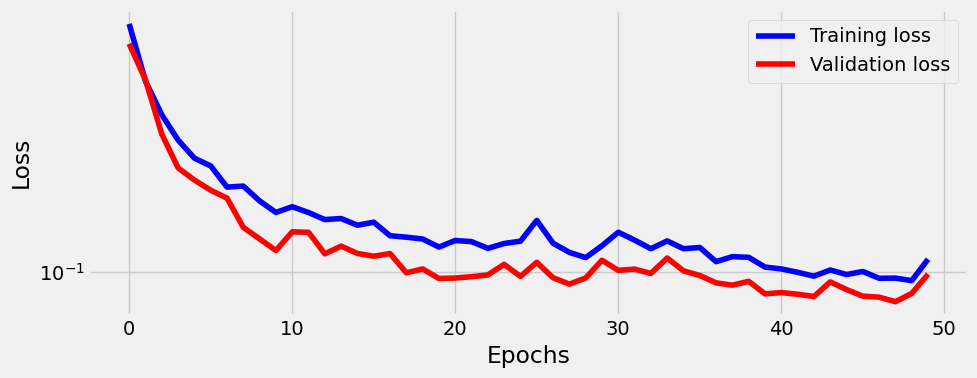

In [72]:
_ = sbs.plot_losses()

We'll use multiclass Jaccard index (aka Interesection over Union) to quantify the model. We'll go over batches, and find `jaccard_index` for each batch:

In [98]:
val_loader_iter = iter(val_loader)
jaccard_indices = []
for x_val, y_val in val_loader_iter:
    y_pred = sbs.predict(x_val, to_numpy=False).argmax(1)
    jaccard_indices.append(jaccard_index(y_pred, y_val, task="multiclass", num_classes=4))
sbs.metric = np.array(jaccard_indices).mean()
sbs.metric

0.565948

and this is a pretty high value.

Let's save the model:

In [111]:
metric_name = 'jaccard_index'
sbs.save_checkpoint(run_folder / (get_current_datetime() + '_' + 'checkpoint_ ' + metric_name + '_' + f'{sbs.metric:.3f}' + '.tar'))

to load the model reinitialize the `sbs` (with model, optimizer, and loss), then run:

In [100]:
# sbs.load_checkpoint(unlabeled_dir / 'runs/2023_01_19_11_30_four_class_segnet/2023_01_19_12_17_checkpoint_ jaccard_index_0.606.tar')

# Visualize predictions

Let's visualize some of the predictions for `val_loader`:

In [101]:
inv_normalizer = InverseNormalize(normalizer)

In [102]:
def convert_class_mask_to_rgb_image(im):
    b = np.zeros([im.shape[0], im.shape[1], 3], dtype='uint8')
    for class_id in range(3):
        b[:,:,class_id] = np.array((im == (class_id+1))*255, dtype='uint8')
    return b


def save_image(im: Image, filepath: Path, overwrite: bool = False):
    if filepath.exists() and not overwrite:
        print('File exists and overwrite flag is False')
        return
    filepath.parent.mkdir(parents=True, exist_ok=True)
    im.save(filepath, "PNG")
    
        
def display_images(x_batch, y_batch, y_pred_batch, idx_offset=0, save=False, overwrite=False):
    if len(x_batch) > 64:
        raise Warning(f"There are {len(x_batch)} images to show, I set the limit to 64.")
        return

    for idx in range(len(x_batch)):
        # convert to PIL images
        prediction = ToPILImage()(convert_class_mask_to_rgb_image(y_pred_batch[idx,:,:]))
        label_mask = ToPILImage()(y_batch[idx,:,:].float())
        original = ToPILImage()(inv_normalizer(x_batch[idx,:,:,:]))
        overlayed = overlay_two_images(original, prediction, alpha=0.5, to_numpy=False)
        
        name = '' if not idx_map else idx_map[idx_offset + idx]
        if not save:
            fig, ax = plt.subplots(1,4)
            ax[0].imshow(prediction)
            ax[0].set_title(f"{idx_offset + idx} - {name}")
            ax[1].imshow(label_mask)
            ax[2].imshow(original)
            ax[3].imshow(overlayed)
            for i in range(4):
                ax[i].grid(False)
                ax[i].xaxis.set_major_locator(ticker.NullLocator())
                ax[i].yaxis.set_major_locator(ticker.NullLocator())
            plt.show()
        else:
            if not idx_map:
                raise ValueError('If save=True, idx_map must be provided.')
            save_image(prediction, run_folder / 'predicted' / name, overwrite)
            save_image(overlayed, run_folder / 'overlayed' / name, overwrite)

In [103]:
val_loader_iter = iter(val_loader)

In [104]:
x_val, y_val = next(val_loader_iter)

In [105]:
y_pred = sbs.predict(x_val, to_numpy=False).argmax(1)
y_pred = y_pred.masked_fill_(y_val == -1, 0)

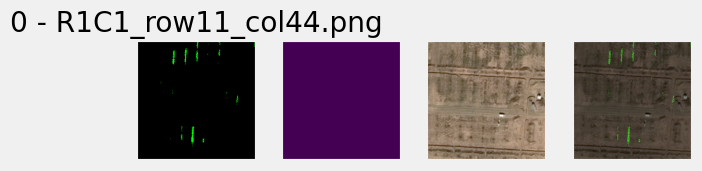

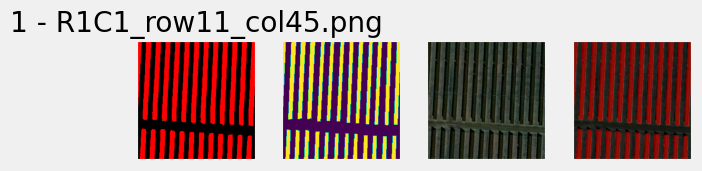

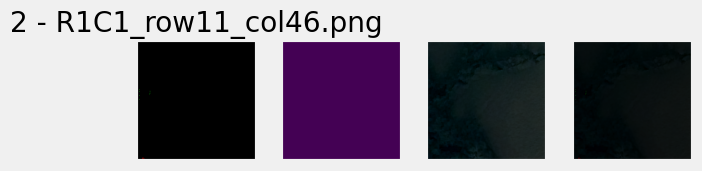

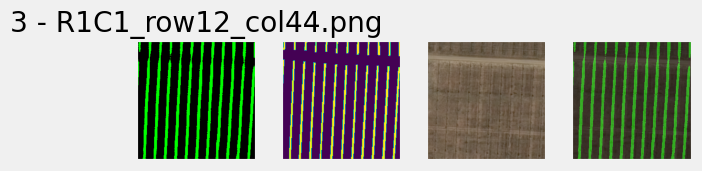

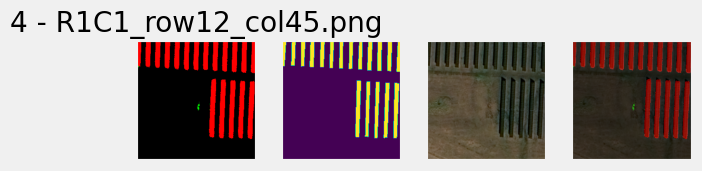

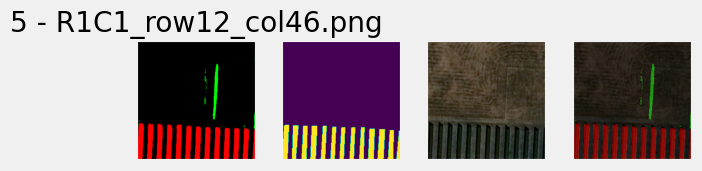

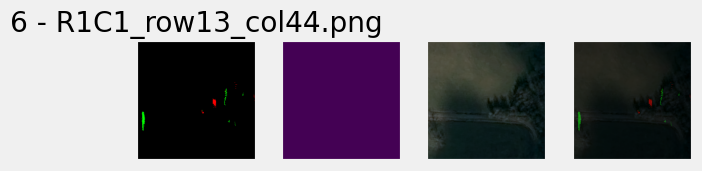

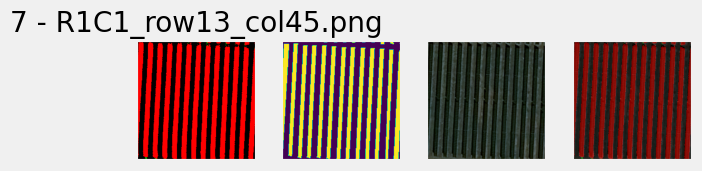

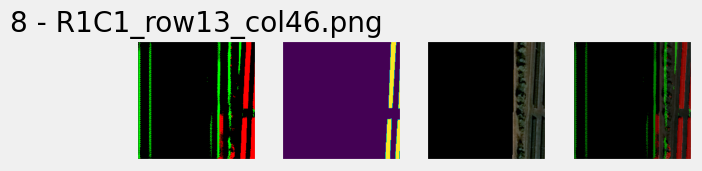

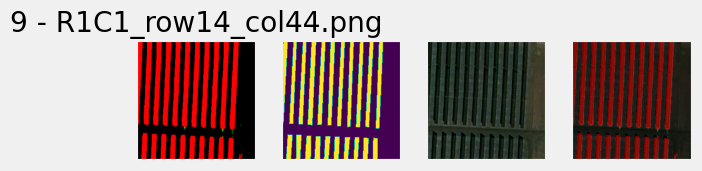

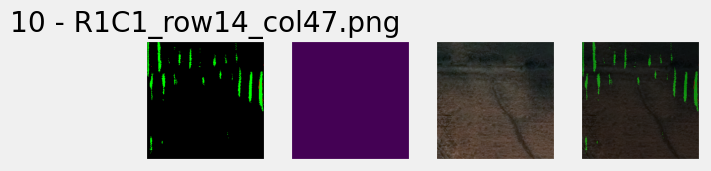

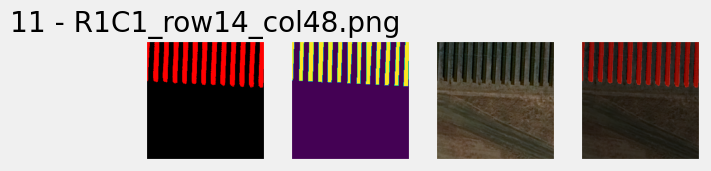

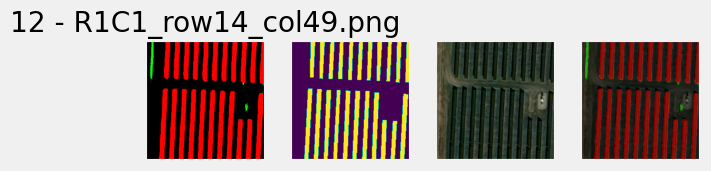

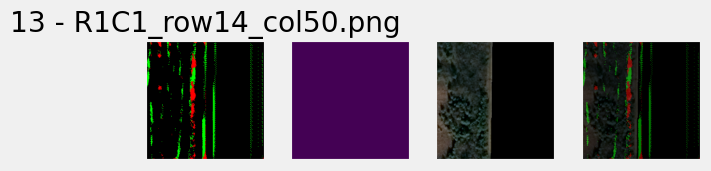

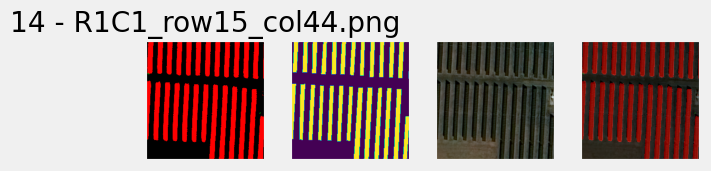

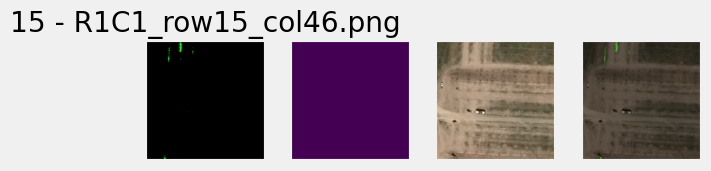

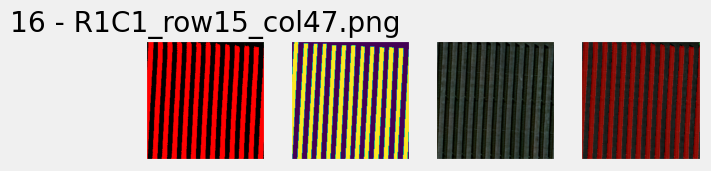

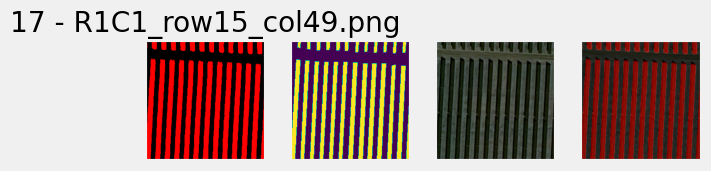

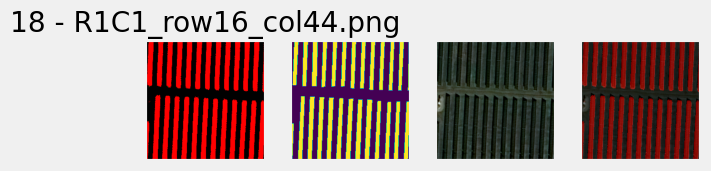

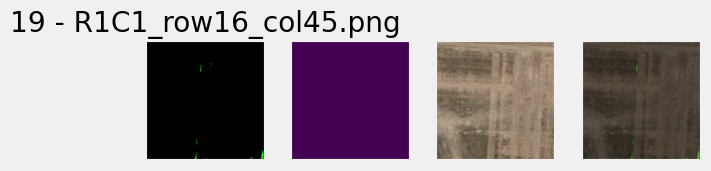

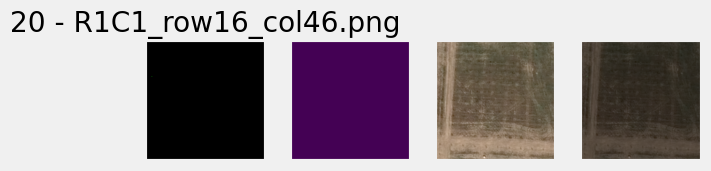

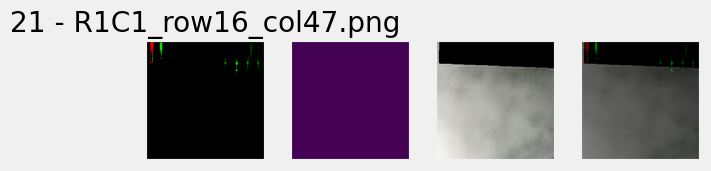

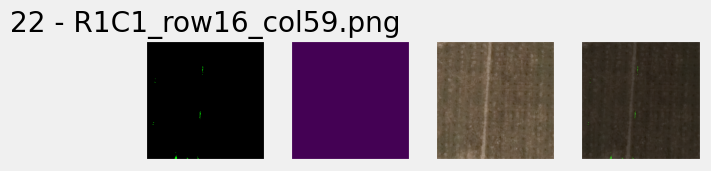

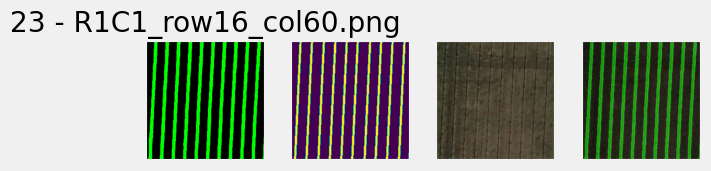

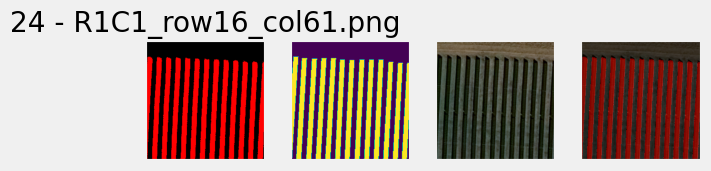

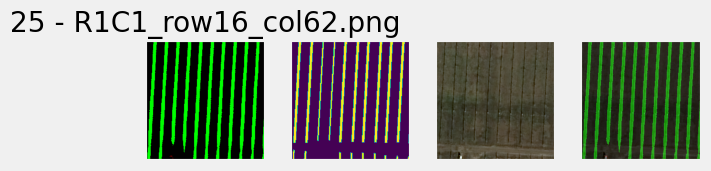

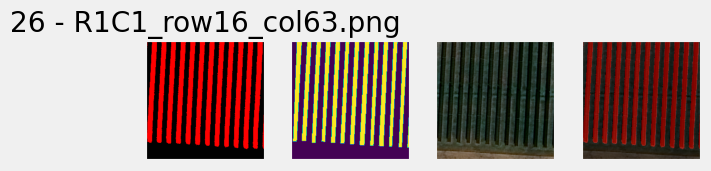

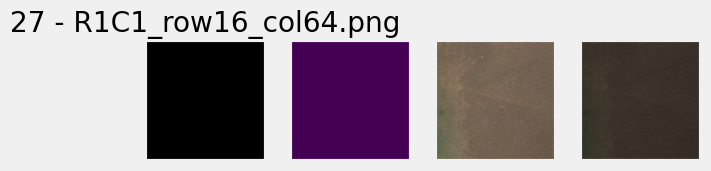

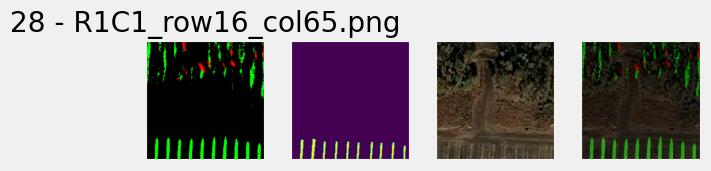

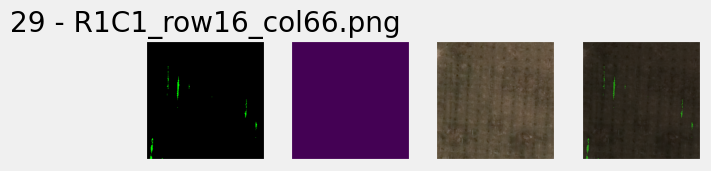

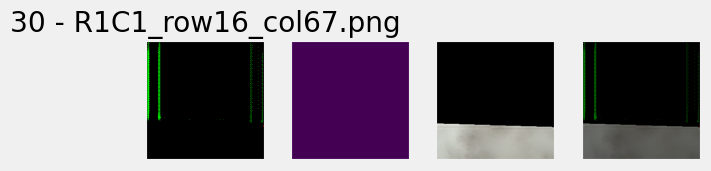

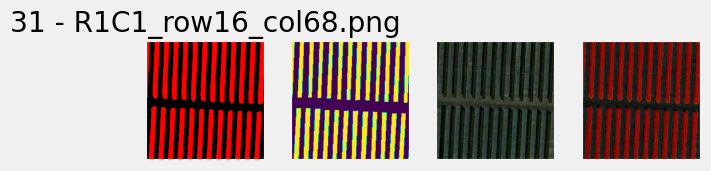

In [106]:
display_images(x_val, y_val, y_pred)

# Predictions on unlabeled data

In [107]:
unlabeled_dataset = TransformedTensorDataset(unlabeled_tensor_x, unlabeled_tensor_y, transform=val_composer)
batch_size = 32
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size)

In [108]:
unlabeled_loader_iter = iter(unlabeled_loader)
batch_idx = 0
for x_unlabeled_batch, y_unlabeled_batch in tqdm(unlabeled_loader_iter):
    y_unlabeled_pred_batch = sbs.predict(x_unlabeled_batch, to_numpy=False).argmax(1)
    y_unlabeled_pred_batch = y_unlabeled_pred_batch.masked_fill_(y_unlabeled_batch == -1, 0)
    display_images(x_unlabeled_batch, y_unlabeled_batch, y_unlabeled_pred_batch, batch_idx*batch_size, save=True, overwrite=True) 
    batch_idx += 1

100%|██████████| 203/203 [08:24<00:00,  2.49s/it]


In [142]:
big_image = BigImage('R1C1')

big_image.stitch_images(run_folder / 'predicted', 
                        run_folder / (big_image.tag + '_predicted.png'))

big_image.stitch_images(run_folder / 'overlayed', 
                        run_folder / (big_image.tag + '_overlayed.png'))

Expect 1-2 minutes ...
File was not found, using defaults.


2038it [00:02, 1002.58it/s]


Done stitching to: /home/runs/2023_01_23_11_23_three_class_segnet_all_pixels_gpu/R1C1_predicted.png
Expect 1-2 minutes ...
File was not found, using defaults.


2038it [00:04, 415.11it/s]


Done stitching to: /home/runs/2023_01_23_11_23_three_class_segnet_all_pixels_gpu/R1C1_overlayed.png
